# Регрессия на гауссовских процессах

In [1]:
import pandas as pd 
import numpy as np
import plotly.express as px

data = pd.read_excel("./data/sem_14/data.xlsx", index_col=0)
# data.index = pd.to_datetime(data.index, format="%d.%m.%Y")
data = data.reset_index(drop=True)
data = data.loc[:, 'Capesize']

data.loc[(data.index > 100) & (data.index < 130)] = np.nan

In [2]:
px.line(data)

In [3]:
data.isna().sum(axis=0)

39

In [4]:
X, y = data.index.values, data.values

X_train, y_train = data.loc[~data.isna()].index.values.reshape(-1,1),  data.loc[~data.isna()].values
X_test = data.loc[data.isna()].index.values.reshape(-1,1)

X_test = np.linspace(X_train.min(), X_train.max(), 2000).reshape(-1,1)

In [13]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, ConstantKernel, Matern


# kernel =  1.0*Matern() +  WhiteKernel(noise_level=1) + DotProduct()
kernel =  1.0*RBF() +  WhiteKernel(noise_level=1)

gpr = GaussianProcessRegressor(
    kernel=kernel,
    random_state=0).fit(X_train, y_train)

mean, std = gpr.predict(X_test, return_std=True)


C:\Users\zehov\Desktop\current_projects\hse_ts_course\venv\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

C:\Users\zehov\Desktop\current_projects\hse_ts_course\venv\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.



In [14]:
gpr.log_marginal_likelihood()

-2384.3956828569762

In [15]:
gpr.kernel_

316**2 * RBF(length_scale=29.8) + WhiteKernel(noise_level=1e+05)

In [16]:



import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=X, y=y,
    fill=None,
    mode='lines',
    line_color='indigo',
    ))

fig.add_trace(go.Scatter(
    x=X_test.ravel(),
    y=mean.ravel(),
    fill=None, # fill area between trace0 and trace1
    mode='lines', line_color='indigo'))

fig.add_trace(go.Scatter(
    x=X_test.ravel(),
    y=mean.ravel() - 2*std,
    fill=None, # fill area between trace0 and trace1
    mode='lines'))

fig.add_trace(go.Scatter(
    x=X_test.ravel(),
    y=mean + 2*std,
    fill=None, # fill area between trace0 and trace1
    mode='lines'))

fig.show()

In [4]:
import matplotlib.pyplot as plt 

In [5]:
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

# Target Function

https://github.com/fmfn/BayesianOptimization/blob/master/examples/visualization.ipynb

Lets create a target 1-D function with multiple local maxima to test and visualize how the [BayesianOptimization](https://github.com/fmfn/BayesianOptimization) package works. The target function we will try to maximize is the following:

$$f(x) = e^{-(x - 2)^2} + e^{-\frac{(x - 6)^2}{10}} + \frac{1}{x^2 + 1}, $$ 

its maximum is at $x = 2$ and we will restrict the interval of interest to $x \in (-2, 10)$.

Notice that, in practice, this function is unknown, the only information we have is obtained by sequentialy probing it at different points. Bayesian Optimization works by contructing a posterior distribution of functions that best fit the data observed and chosing the next probing point by balancing exploration and exploitation.

In [6]:
def target(x):
    return np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2/10) + 1/ (x**2 + 1)

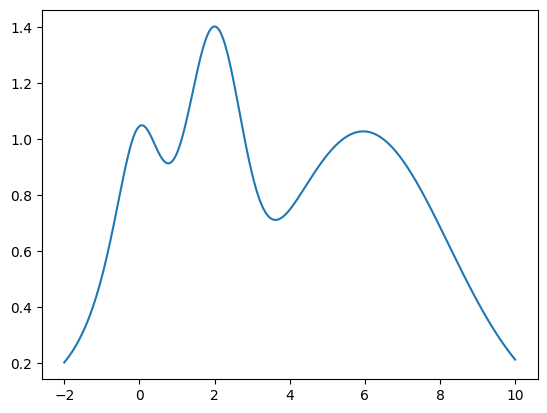

In [7]:
import matplotlib.pyplot as plt
x = np.linspace(-2, 10, 10000).reshape(-1, 1)
y = target(x)

plt.plot(x, y);

# Create a BayesianOptimization Object

Enter the target function to be maximized, its variable(s) and their corresponding ranges. A minimum number of 2 initial guesses is necessary to kick start the algorithms, these can either be random or user defined.

In [8]:
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

optimizer = BayesianOptimization(target, {'x': (-2, 10)}, random_state=27)

In this example we will use the Upper Confidence Bound (UCB) as our utility function. It has the free parameter
$\kappa$ which control the balance between exploration and exploitation; we will set $\kappa=5$ which, in this case, makes the algorithm quite bold.

In [9]:
acq_function = UtilityFunction(kappa=5)

optimizer.maximize(init_points=3, n_iter=0, acquisition_function=acq_function)

|   iter    |  target   |     x     |
-------------------------------------
| 1         | 0.8198    | 3.109     |
| 2         | 0.746     | 7.775     |
| 3         | 0.9553    | 6.825     |


# Plotting and visualizing the algorithm at each step

### Let's first define a couple functions to make plotting easier

In [10]:

def posterior(optimizer, x_obs, y_obs, grid):
    optimizer._gp.fit(x_obs, y_obs)

    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma

def plot_gp(optimizer, x, y):
    fig = plt.figure(figsize=(16, 10))
    steps = len(optimizer.space)
    fig.suptitle(
        'Gaussian Process and Utility Function After {} Steps'.format(steps),
        fontdict={'size':30}
    )
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    x_obs = np.array([[res["params"]["x"]] for res in optimizer.res])
    y_obs = np.array([res["target"] for res in optimizer.res])
    
    mu, sigma = posterior(optimizer, x_obs, y_obs, x)
    axis.plot(x, y, linewidth=3, label='Target')
    axis.plot(x_obs.flatten(), y_obs, 'D', markersize=8, label=u'Observations', color='r')
    axis.plot(x, mu, '--', color='k', label='Prediction')

    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='95% confidence interval')
    
    axis.set_xlim((-2, 10))
    axis.set_ylim((None, None))
    axis.set_ylabel('f(x)', fontdict={'size':20})
    axis.set_xlabel('x', fontdict={'size':20})
    
    utility_function = UtilityFunction(kind="ucb", kappa=5, xi=0)
    utility = utility_function.utility(x, optimizer._gp, 0)
    acq.plot(x, utility, label='Utility Function', color='purple')
    acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    acq.set_xlim((-2, 10))
    acq.set_ylim((0, np.max(utility) + 0.5))
    acq.set_ylabel('Utility', fontdict={'size':20})
    acq.set_xlabel('x', fontdict={'size':20})
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

### Two random points

After we probe two points at random, we can fit a Gaussian Process and start the bayesian optimization procedure. Two points should give us a uneventful posterior with the uncertainty growing as we go further from the observations.

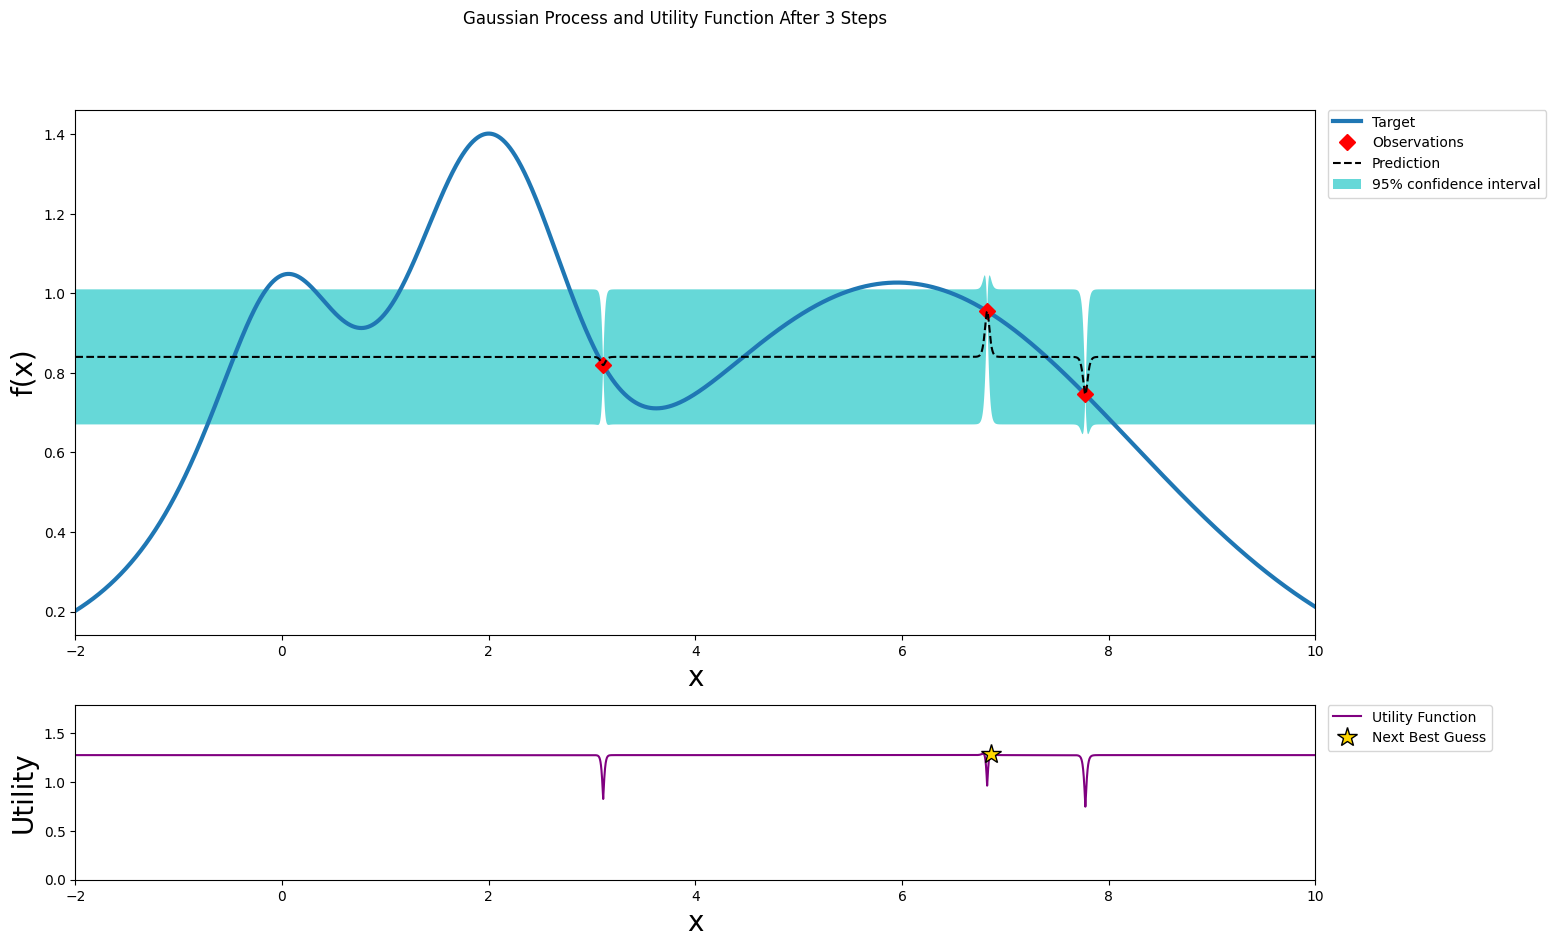

In [11]:
plot_gp(optimizer, x, y)

### After one step of GP (and two random points)

|   iter    |  target   |     x     |
-------------------------------------
| 4         | 0.9597    | 6.797     |


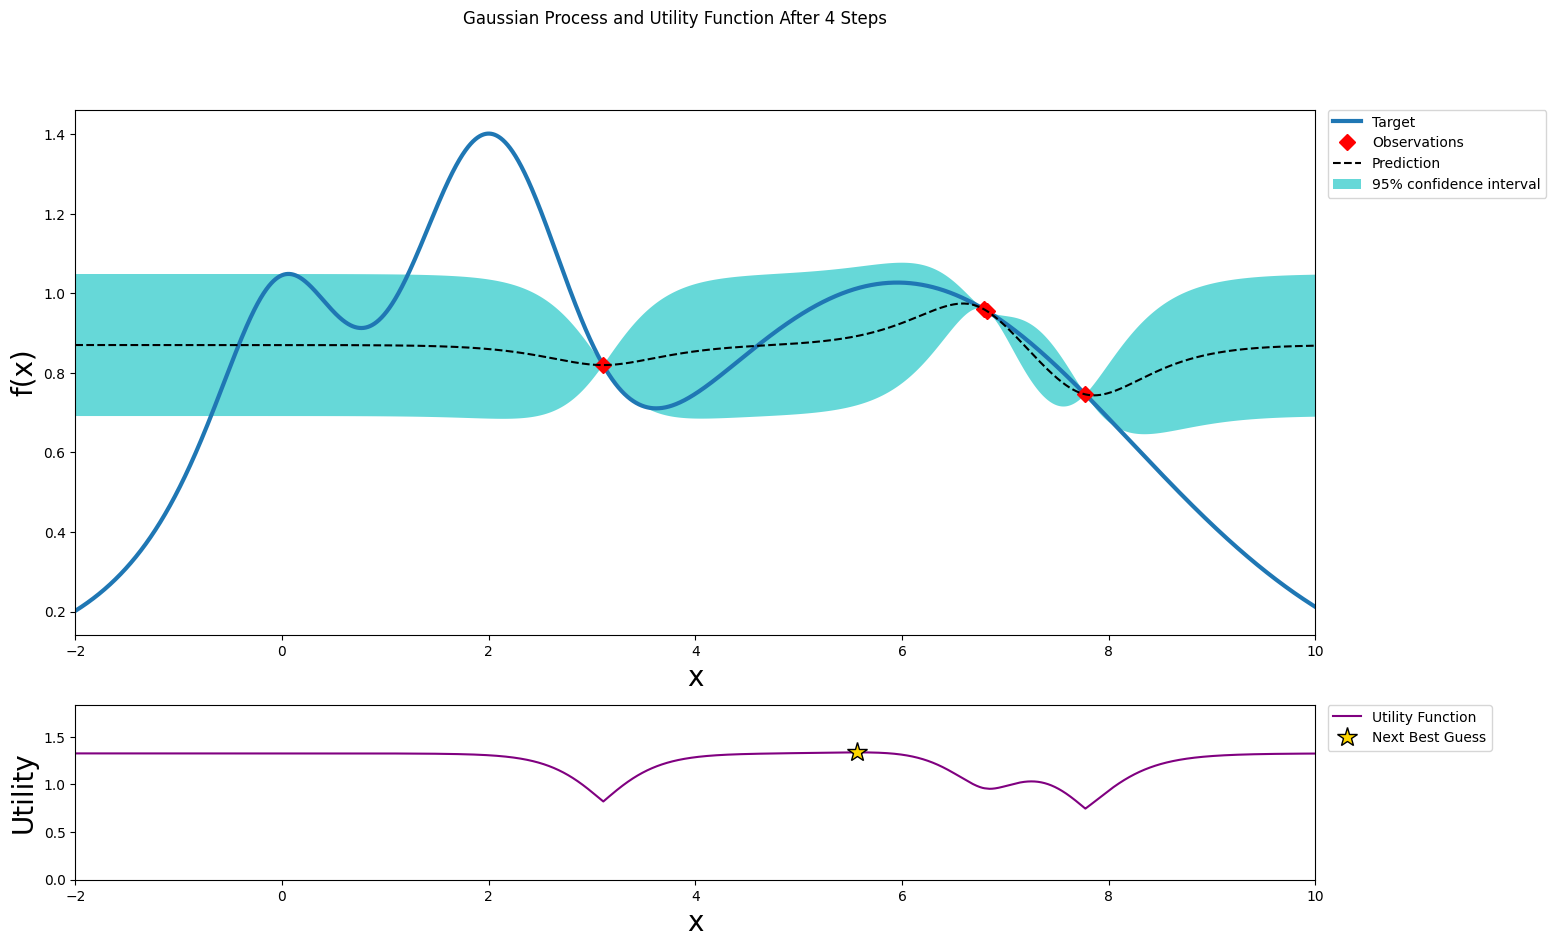

In [12]:
optimizer.maximize(init_points=0, n_iter=1)
plot_gp(optimizer, x, y)

### After two steps of GP (and two random points)

|   iter    |  target   |     x     |
-------------------------------------
| 5         | 1.027     | 5.872     |


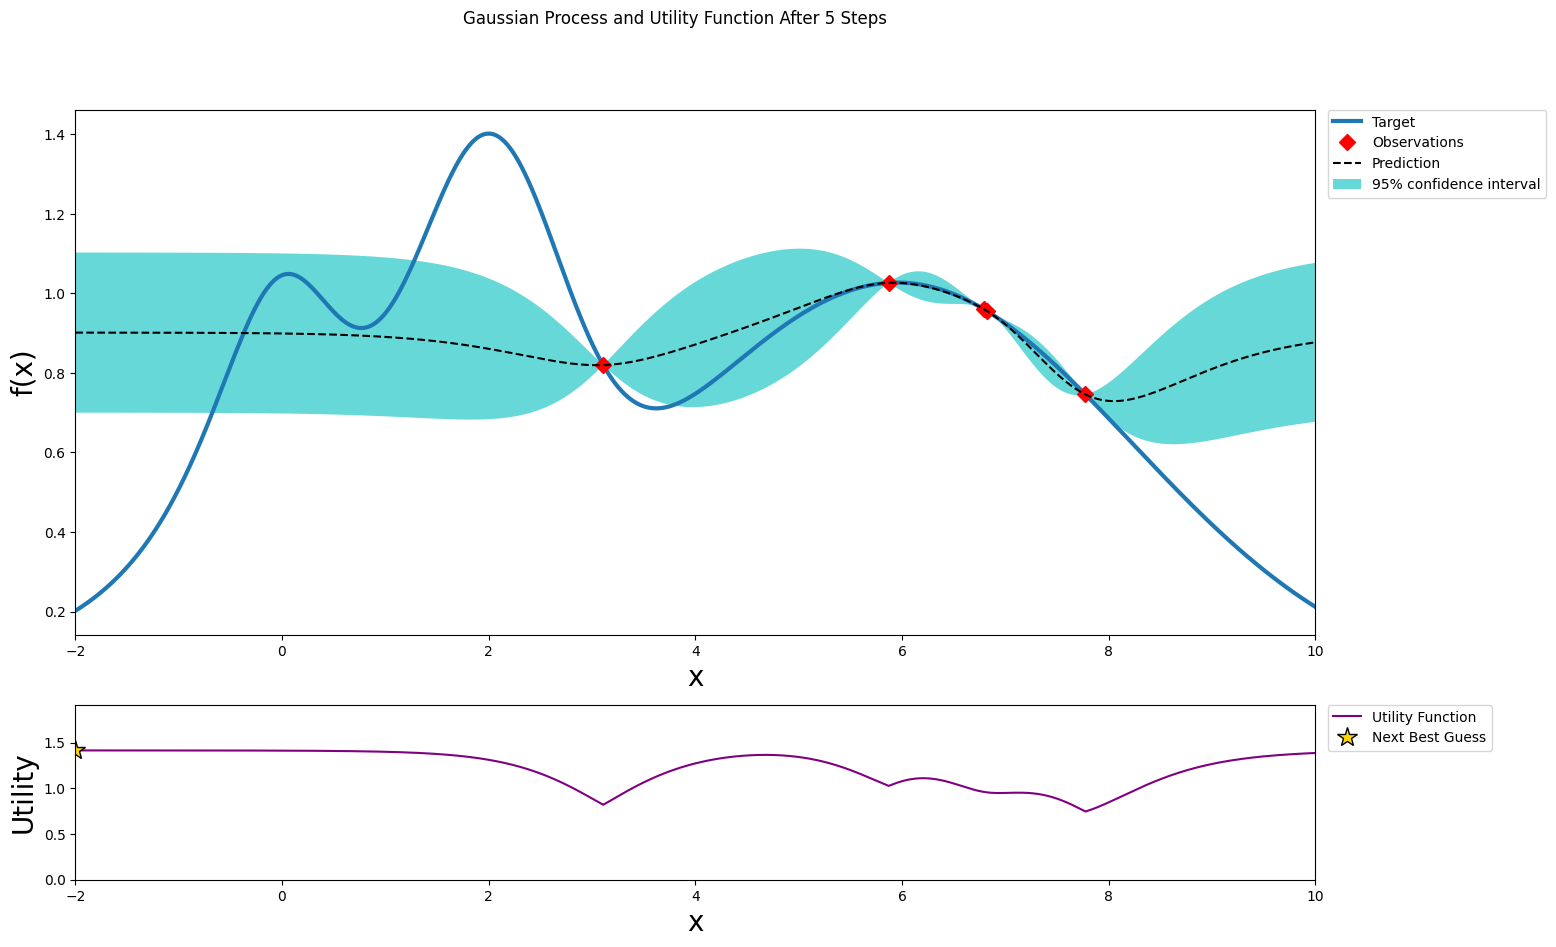

In [13]:
optimizer.maximize(init_points=0, n_iter=1)
plot_gp(optimizer, x, y)

### After three steps of GP (and two random points)

|   iter    |  target   |     x     |
-------------------------------------
| 6         | 0.2017    | -2.0      |


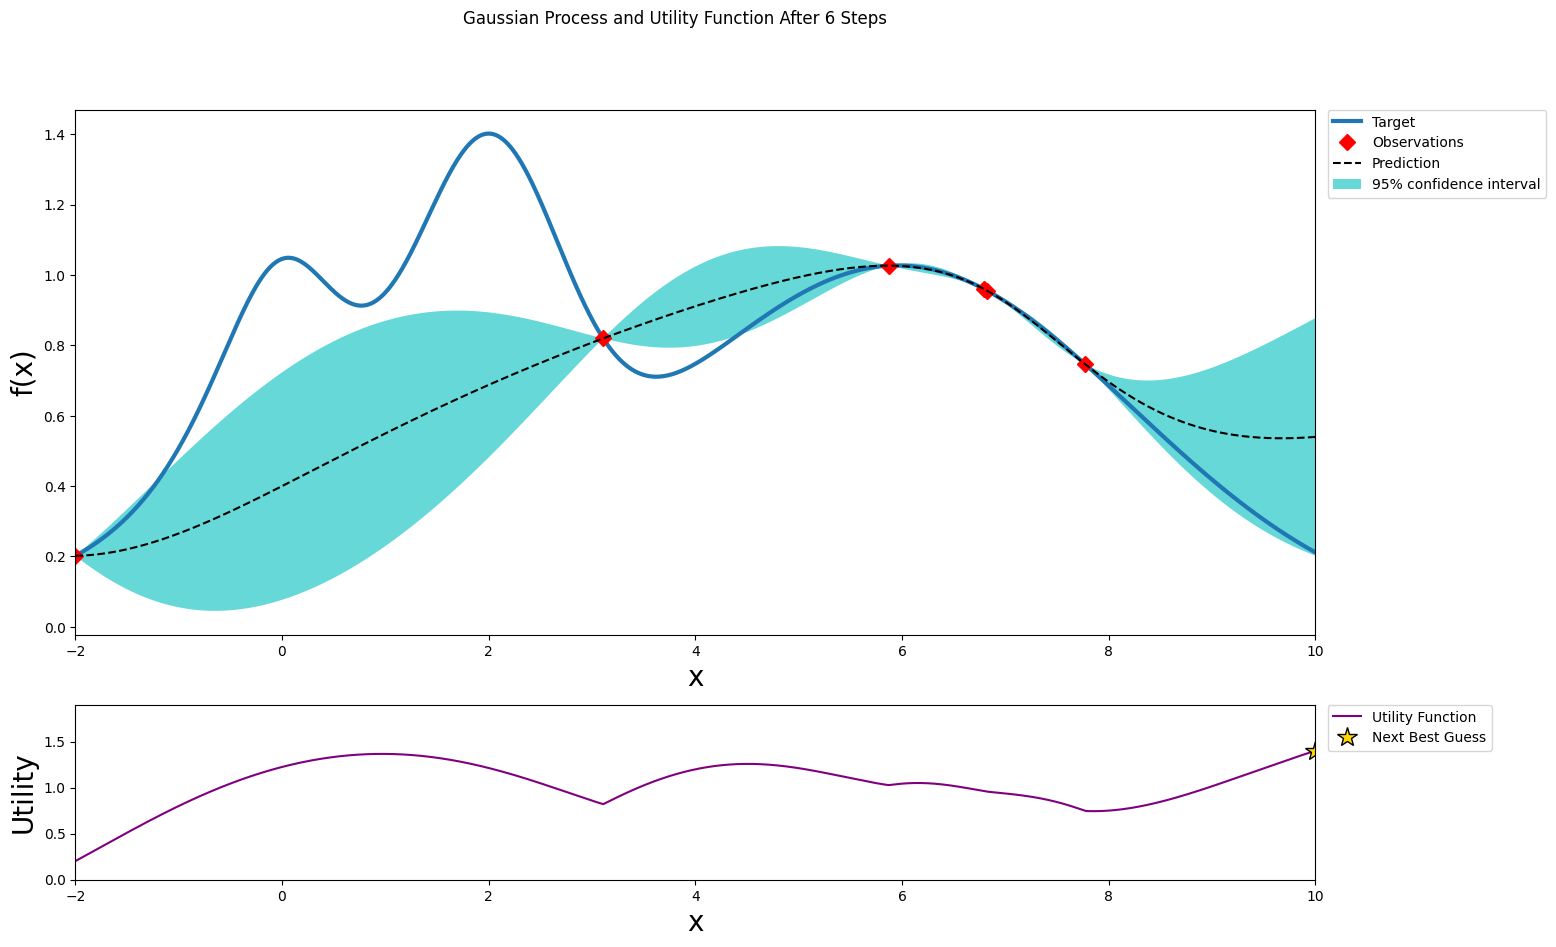

In [14]:
optimizer.maximize(init_points=0, n_iter=1)
plot_gp(optimizer, x, y)

### After four steps of GP (and two random points)

|   iter    |  target   |     x     |
-------------------------------------
| 7         | 0.8864    | 4.689     |


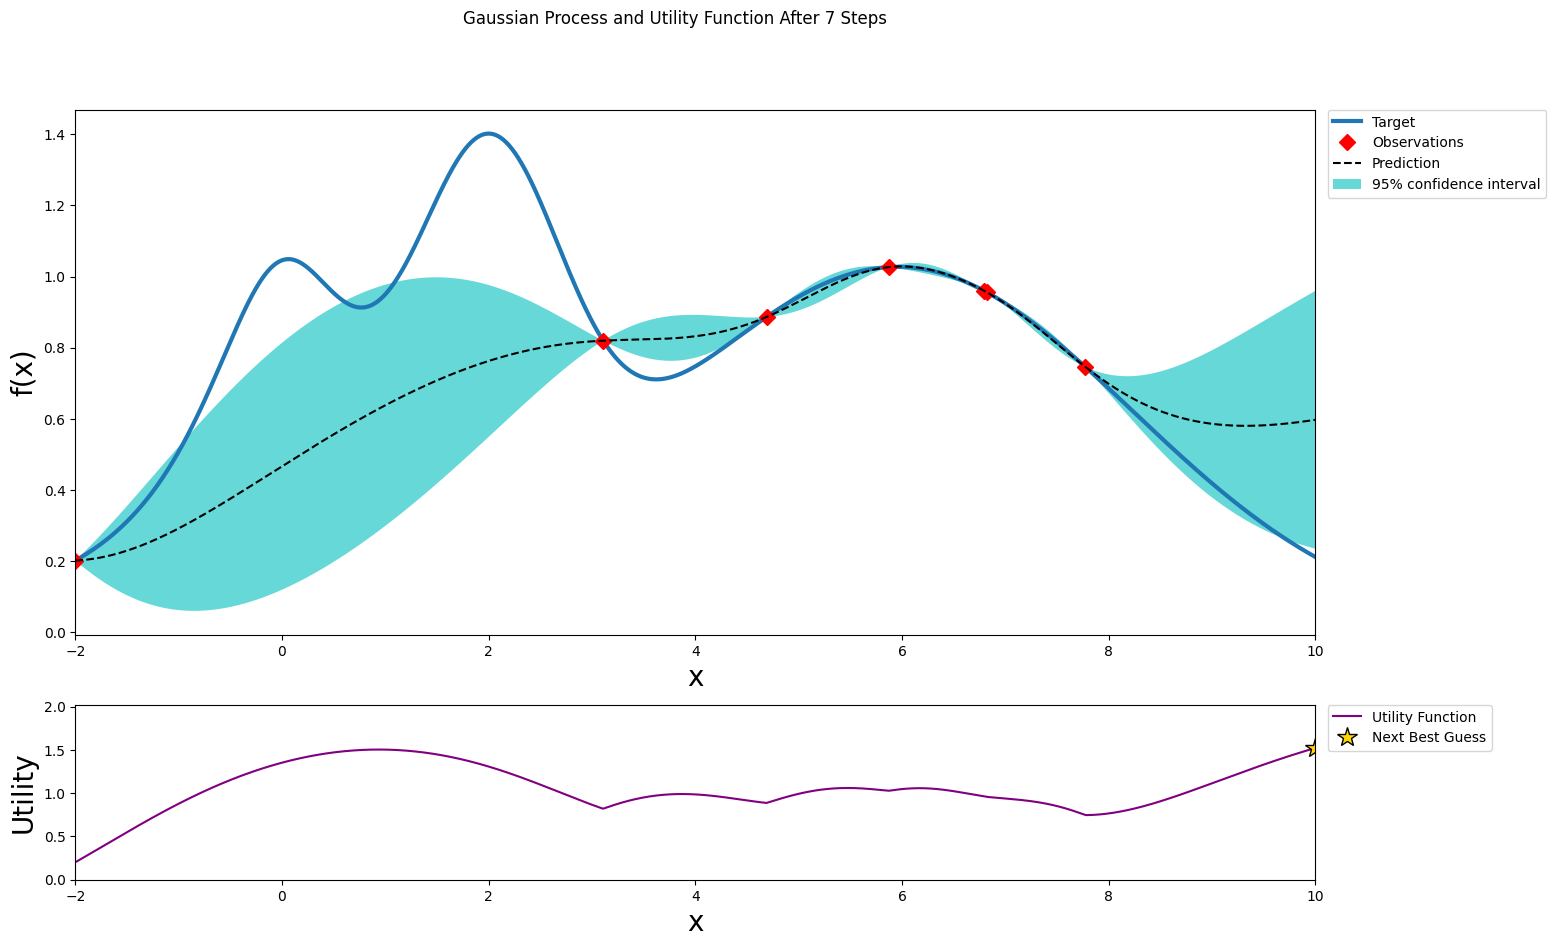

In [15]:
optimizer.maximize(init_points=0, n_iter=1)
plot_gp(optimizer, x, y)

### After five steps of GP (and two random points)

|   iter    |  target   |     x     |
-------------------------------------
| 8         | 1.095     | 1.302     |


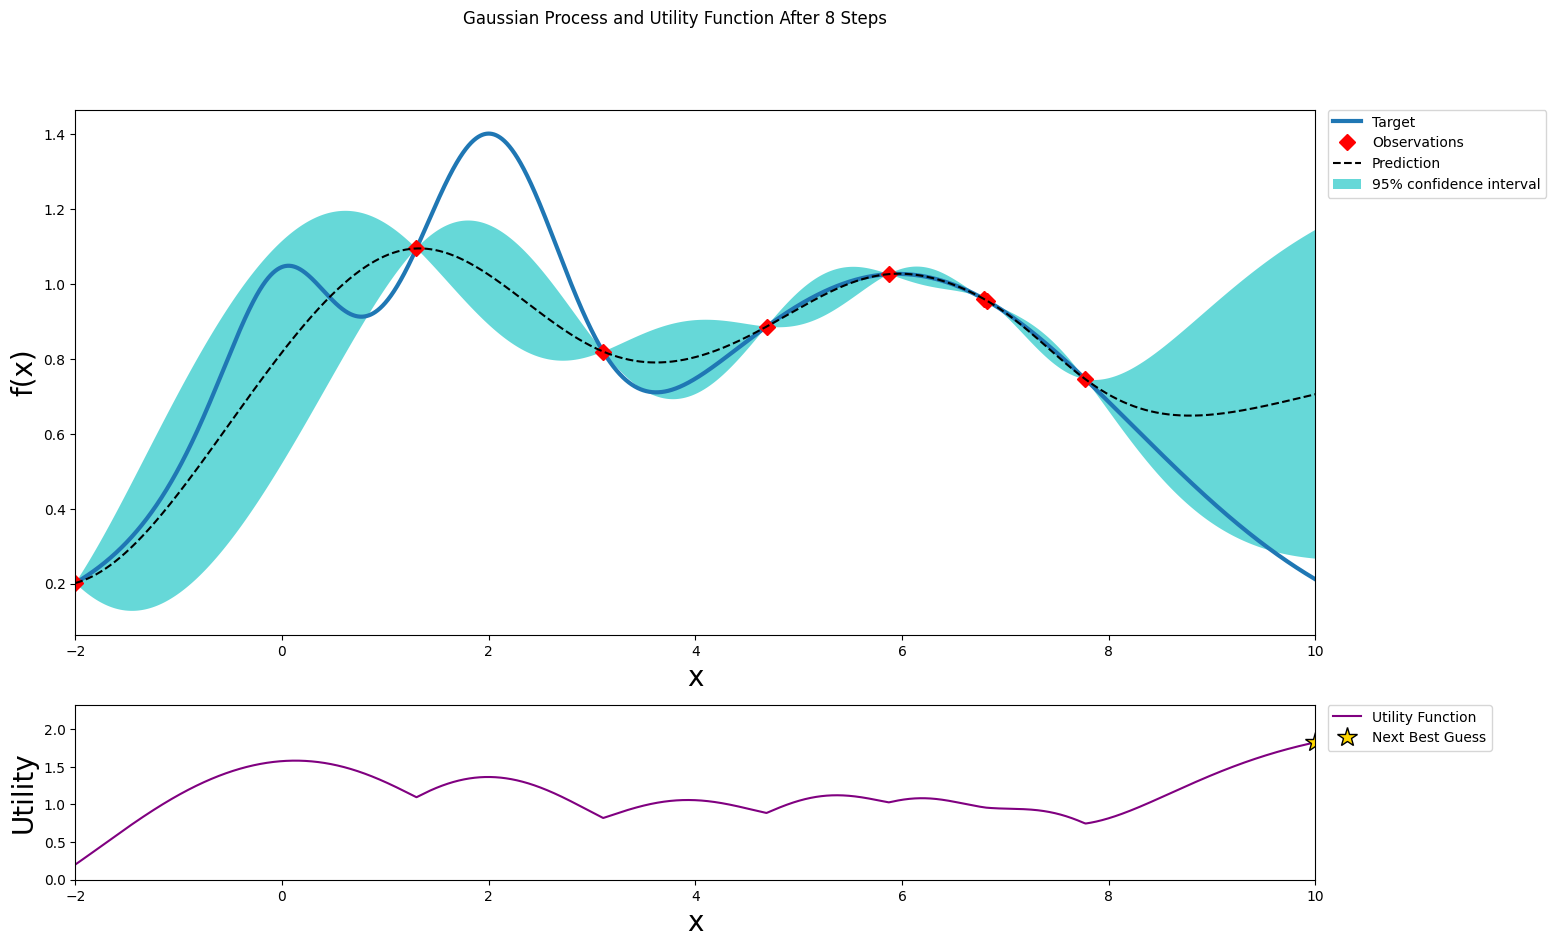

In [16]:
optimizer.maximize(init_points=0, n_iter=1)
plot_gp(optimizer, x, y)

### After six steps of GP (and two random points)

|   iter    |  target   |     x     |
-------------------------------------
| 9         | 0.2118    | 10.0      |


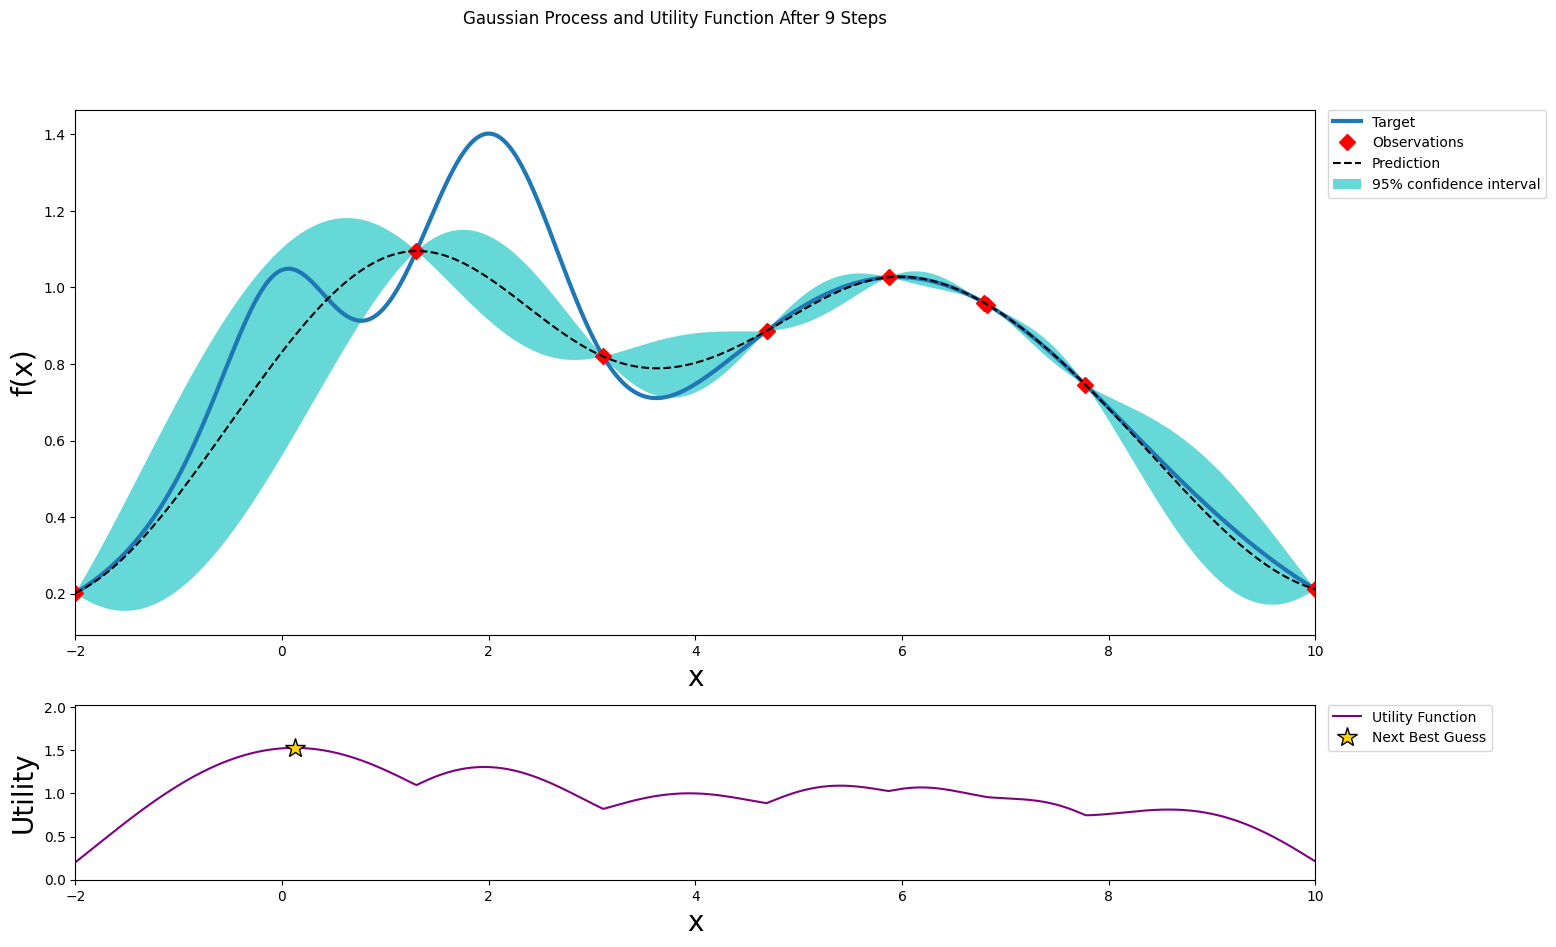

In [17]:
optimizer.maximize(init_points=0, n_iter=1)
plot_gp(optimizer, x, y)

### After seven steps of GP (and two random points)

|   iter    |  target   |     x     |
-------------------------------------
| 10        | 0.9613    | 0.4735    |


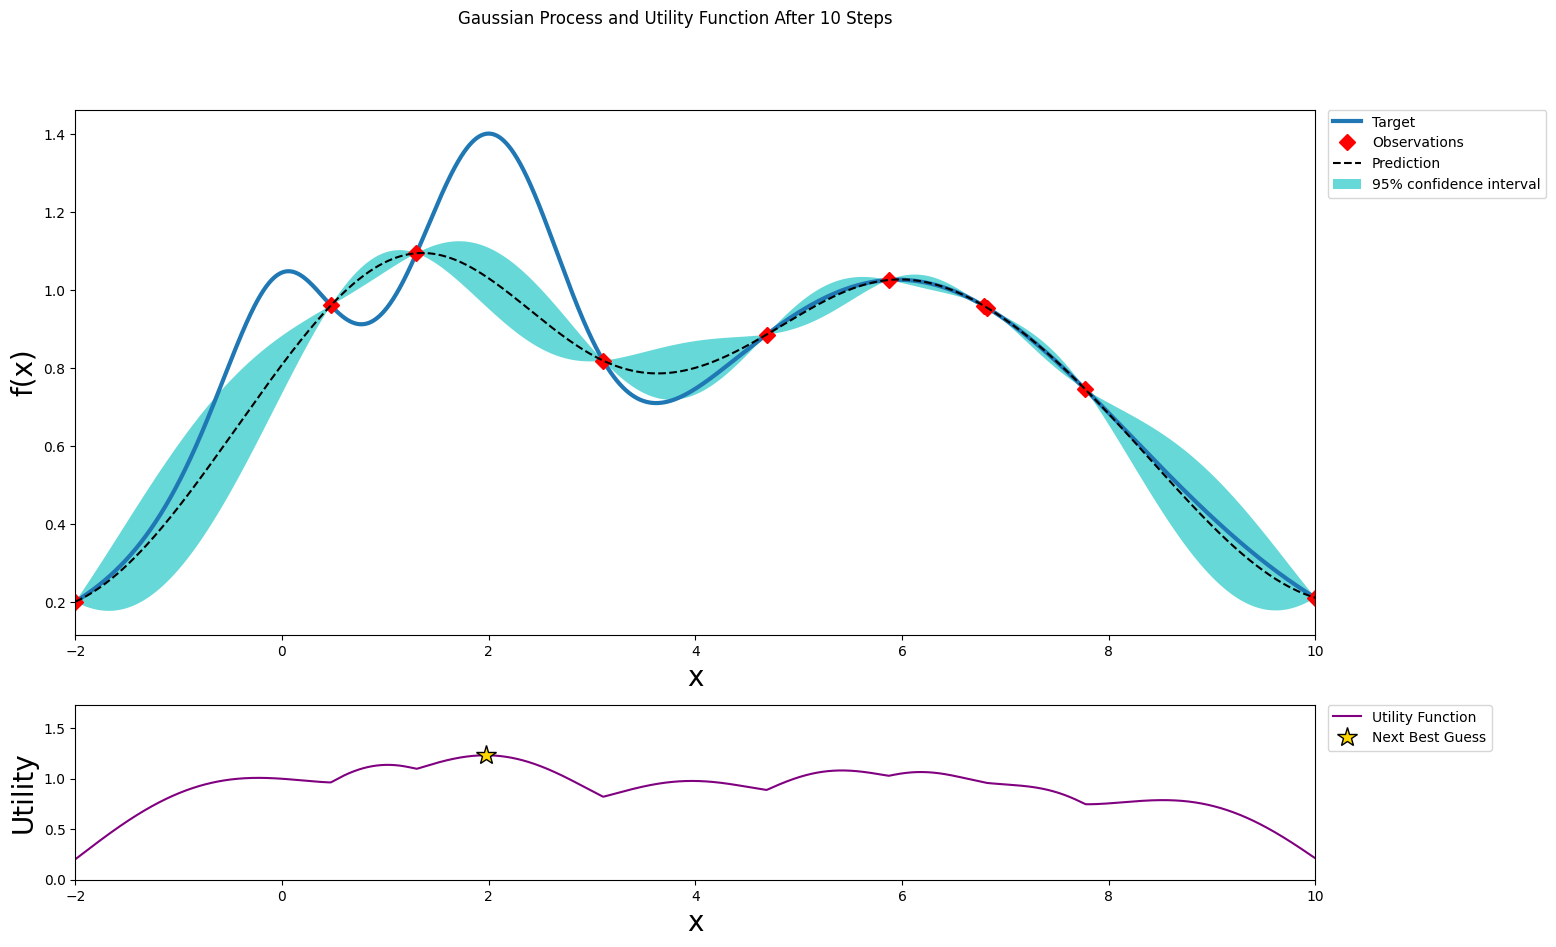

In [18]:
optimizer.maximize(init_points=0, n_iter=1)
plot_gp(optimizer, x, y)

# Stopping

After just a few points the algorithm was able to get pretty close to the true maximum. It is important to notice that the trade off between exploration (exploring the parameter space) and exploitation (probing points near the current known maximum) is fundamental to a succesful bayesian optimization procedure. The utility function being used here (Upper Confidence Bound - UCB) has a free parameter $\kappa$ that allows the user to make the algorithm more or less conservative. Additionally, a the larger the initial set of random points explored, the less likely the algorithm is to get stuck in local minima due to being too conservative.

## VAR process

In [21]:
from sktime.forecasting.var import VAR
from sktime.datasets import load_longley
_, y = load_longley()
forecaster = VAR()  
forecaster.fit(y)  

y_pred = forecaster.predict(fh=[1,2,3])  

In [20]:
load_longley()

(Period
 1947    60323.0
 1948    61122.0
 1949    60171.0
 1950    61187.0
 1951    63221.0
 1952    63639.0
 1953    64989.0
 1954    63761.0
 1955    66019.0
 1956    67857.0
 1957    68169.0
 1958    66513.0
 1959    68655.0
 1960    69564.0
 1961    69331.0
 1962    70551.0
 Freq: A-DEC, Name: TOTEMP, dtype: float64,
         GNPDEFL       GNP   UNEMP   ARMED       POP
 Period                                             
 1947       83.0  234289.0  2356.0  1590.0  107608.0
 1948       88.5  259426.0  2325.0  1456.0  108632.0
 1949       88.2  258054.0  3682.0  1616.0  109773.0
 1950       89.5  284599.0  3351.0  1650.0  110929.0
 1951       96.2  328975.0  2099.0  3099.0  112075.0
 1952       98.1  346999.0  1932.0  3594.0  113270.0
 1953       99.0  365385.0  1870.0  3547.0  115094.0
 1954      100.0  363112.0  3578.0  3350.0  116219.0
 1955      101.2  397469.0  2904.0  3048.0  117388.0
 1956      104.6  419180.0  2822.0  2857.0  118734.0
 1957      108.4  442769.0  2936.0  2798

In [22]:
forecaster._fitted_forecaster.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 23, May, 2023
Time:                     18:41:57
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    52.9212
Nobs:                     15.0000    HQIC:                   51.4900
Log likelihood:          -462.709    FPE:                2.95857e+22
AIC:                      51.5051    Det(Omega_mle):     5.50100e+21
--------------------------------------------------------------------
Results for equation GNPDEFL
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const            269.683886       112.669122            2.394           0.017
L1.GNPDEFL        -0.370480         0.403828           -0.917           0.359
L1.GNP             0.000271         0.000096            2.806         

In [24]:
y_pred

GNPDEFL            GNP        UNEMP        ARMED            POP
1963  119.850676  573753.413300  4890.128398  2535.356545  132493.093697
1964  121.468483  596746.410265  5633.310536  2150.219863  134981.099616
1965  124.127716  629948.315301  5881.901495  1855.953946  137613.083699

In [26]:
from statsmodels.tsa.stattools import grangercausalitytests

grangercausalitytests(y.loc[:, ("POP", "GNP")], 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2008  , p=0.6621  , df_denom=12, df_num=1
ssr based chi2 test:   chi2=0.2510  , p=0.6164  , df=1
likelihood ratio test: chi2=0.2489  , p=0.6179  , df=1
parameter F test:         F=0.2008  , p=0.6621  , df_denom=12, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2362  , p=0.7944  , df_denom=9, df_num=2
ssr based chi2 test:   chi2=0.7348  , p=0.6925  , df=2
likelihood ratio test: chi2=0.7161  , p=0.6990  , df=2
parameter F test:         F=0.2362  , p=0.7944  , df_denom=9, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.8985  , p=0.2309  , df_denom=6, df_num=3
ssr based chi2 test:   chi2=12.3404 , p=0.0063  , df=3
likelihood ratio test: chi2=8.6769  , p=0.0339  , df=3
parameter F test:         F=1.8985  , p=0.2309  , df_denom=6, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.5352  , p=0.3775  , df_denom

{1: ({'ssr_ftest': (0.20077047430251427, 0.6620821027011161, 12.0, 1),
   'ssr_chi2test': (0.25096309287814283, 0.616397749137523, 1),
   'lrtest': (0.24888680382684925, 0.6178600060175239, 1),
   'params_ftest': (0.20077047430284956, 0.6620821027008541, 12.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.23617743023305138, 0.794383974803485, 9.0, 2),
   'ssr_chi2test': (0.7347742273917155, 0.6925415008466669, 2),
   'lrtest': (0.716141499606465, 0.6990236174735998, 2),
   'params_ftest': (0.23617743023262316, 0.7943839748038083, 9.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.8985227810499266, 0.23094615534570595, 6.0, 3),
   'ssr_chi2test': (12.34039807682452, 0.006303579416693265, 3),
   'lrtest': (8.67685684752729, 0.03391056311809576, 3),
   'params_ftest': (1.8985227810236969, 0.2309461553498663, 6.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0.